In [185]:
import os
import requests
from tempfile import NamedTemporaryFile
import zipfile
from xml.etree import cElementTree as ET
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


Download and extract dataset

In [186]:
DATASET_URL = os.getenv("DATASET_URL", "https://figshare.com/ndownloader/files/41725659")
DATASET_DIR = os.getenv("DATASET_DIR", "./../data/FracAtlas")

def download_and_extract_dataset(merge_images = True):
    if os.path.exists(DATASET_DIR):
        print("Dataset already downloaded.")
        return

    zip_file = ""
    with NamedTemporaryFile(suffix=".zip") as f:
        zip_file = f.name
        print("Downloading dataset...")
        r = requests.get(DATASET_URL)

        print("Saving dataset to", zip_file)
        f.write(r.content)

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(DATASET_DIR)

    for file in os.listdir(os.path.join(DATASET_DIR, "FracAtlas")):
        src_path = os.path.join(DATASET_DIR, "FracAtlas", file)
        dest_path = os.path.join(DATASET_DIR, file)
        os.rename(src_path, dest_path)
    os.rmdir(os.path.join(DATASET_DIR, "FracAtlas"))

    if merge_images:
        for subdir in ["Fractured", "Non_fractured"]:
            src_dir = os.path.join(DATASET_DIR, "images", subdir)
            dest_dir = os.path.join(DATASET_DIR, "images")
            for file in os.listdir(src_dir):
                src_path = os.path.join(src_dir, file)
                dest_path = os.path.join(dest_dir, file)
                os.rename(src_path, dest_path)
            os.rmdir(src_dir)

    return DATASET_DIR

download_and_extract_dataset()



Dataset already downloaded.


In [187]:
# https://stackoverflow.com/a/10077069
from collections import defaultdict

def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k:v[0] if len(v) == 1 else v for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v) for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
              d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d


In [188]:
def get_image_metadata(image: str):
    if os.path.extsep in image:
        image = os.path.splitext(image)[0]

    annotation_path = os.path.join(
        DATASET_DIR, "Annotations", "PASCAL VOC", image + ".xml"
    )
    with open(annotation_path, "r") as f:
        annotation_etree = ET.XML(f.read())
        annotation = etree_to_dict(annotation_etree)["annotation"]
    # print(annotation)

    if annotation.get("object") is None:
        return {
            "filename": annotation["filename"],
            "width": annotation["size"]["width"],
            "height": annotation["size"]["height"],
            "fractured": False,
        }
    else:
        if type(annotation["object"]) is dict:
            annotation["object"] = [annotation["object"]]
        return {
            "filename": annotation["filename"],
            "width": annotation["size"]["width"],
            "height": annotation["size"]["height"],
            "fractured": True,
            "objects": [
                {
                    "fractured": obj["name"] == "fractured",
                    "bbox": {
                        "xmin": obj["bndbox"]["xmin"],
                        "ymin": obj["bndbox"]["ymin"],
                        "xmax": obj["bndbox"]["xmax"],
                        "ymax": obj["bndbox"]["ymax"],
                    },
                } for obj in annotation["object"]
            ],
        }


def dir_len(dir):
    return len(
        [name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))]
    )

# https://christianbernecker.medium.com/convert-bounding-boxes-from-coco-to-pascal-voc-to-yolo-and-back-660dc6178742
def pascal_voc_to_xywh(x1, y1, x2, y2):
    return [x1,y1, x2 - x1, y2 - y1]



In [189]:
class FracAtlasDataset(Dataset):
    """FracAtlas dataset."""

    def __init__(self, root_dir = DATASET_DIR, transform=None):
        """
        Arguments:
            root_dir (string): The dataset's directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, "images")
        self.images = [get_image_metadata(i) for i in os.listdir(self.images_dir)]
        self.transform = transform

    def __len__(self):
        return dir_len(self.images_dir)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.images_dir,
                                self.images[idx]["filename"])
        image = Image.open(img_name)
        # print(self.images[idx])
        bbox = [list(obj["bbox"].values()) for obj in self.images[idx]["objects"]] if self.images[idx]["fractured"] else []
        bbox = np.array([bbox], dtype=float).reshape(-1, 4)
        # priént(bbox)
        sample = {'image': image, 'bbox': bbox}

        if self.transform:
            sample = self.transform(sample)

        return sample

frac_dataset = FracAtlasDataset()


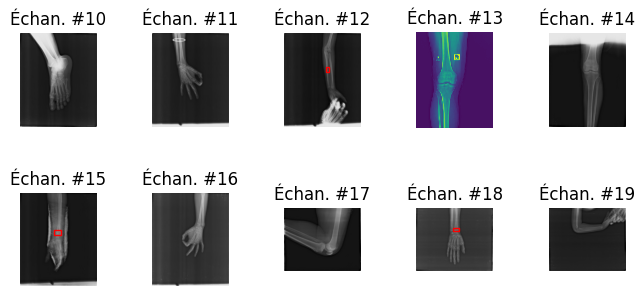

In [190]:

fig = plt.figure()

for i in range(10, 20):
  ax = plt.subplot(3, 5, i - 9)
  plt.tight_layout()
  ax.set_title('Échan. #{}'.format(i))
  ax.axis('off')
  plt.imshow(frac_dataset[i]["image"])
  for bbox in frac_dataset[i]["bbox"]:
    x, y, w, h = pascal_voc_to_xywh(*bbox)
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()


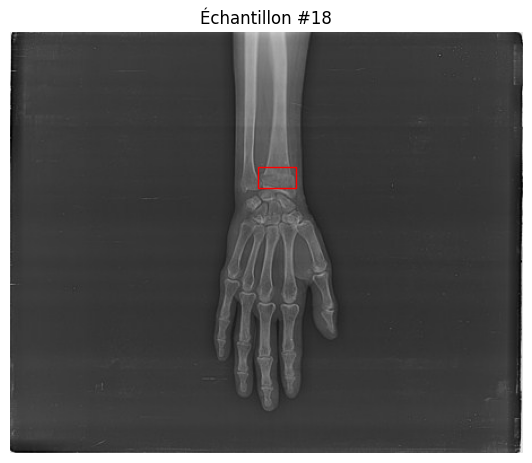

In [191]:
fig = plt.figure()

sample = frac_dataset[18]

ax = plt.subplot()
plt.tight_layout()
ax.set_title('Échantillon #18')
ax.axis('off')
plt.imshow(sample["image"])
for bbox in sample["bbox"]:
  x, y, w, h = pascal_voc_to_xywh(*bbox)
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()
